### Collaborative Filtering

References:
* <https://www.analyticsvidhya.com/blog/2021/05/item-based-collaborative-filtering-build-your-own-recommender-system/>
* <https://towardsdatascience.com/build-a-user-based-collaborative-filtering-recommendation-engine-for-anime-92d35921f304>


In [ ]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
#Read in df
df = pd.read_csv('ratings.csv')
df.head()
#df.shape

FileNotFoundError: ignored

In [ ]:
print('The number of ratings', len(df))
print('The number of users', len(df['userId'].unique()))
print('The number of movies', len(df['movieId'].unique()))

The number of ratings 25000095
The number of users 162541
The number of movies 59047


In [ ]:
# avg number of movies rated per user
import statistics
ratings_per_user = df.groupby('userId')['rating'].count()
print('average number of movies rated per user', statistics.mean(ratings_per_user.tolist()))

average number of movies rated per user 153.80793153727367


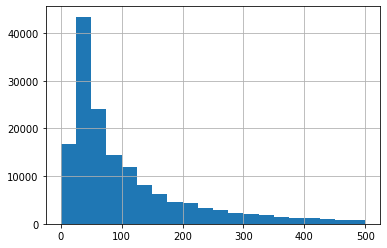

In [ ]:
# distribution of ratings per user
import matplotlib.pyplot as plt
%matplotlib inline
ratings_per_user.hist(bins=20, range=(0,500))

In [ ]:
# avg number of ratings given per movie
ratings_per_movie = df.groupby('movieId')['rating'].count()
print('average number of ratin given per movie: ', statistics.mean(ratings_per_movie.tolist()))

average number of ratin given per movie:  423.3931444442563


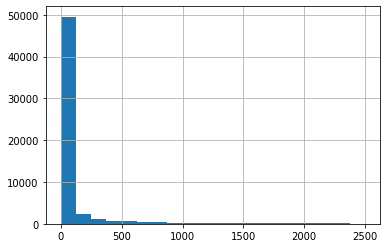

In [ ]:
# distribution of ratings per movie
import matplotlib.pyplot as plt
%matplotlib inline
ratings_per_movie.hist(bins=20, range=(0,2500))

In [ ]:
# counts of ratings per movie as a df
ratings_per_movie_df = pd.DataFrame(ratings_per_movie)
ratings_per_movie_df.shape

(59047, 1)

In [ ]:
# remove if < 1000 ratings
filtered_ratings_per_movie_df = ratings_per_movie_df[ratings_per_movie_df.rating >= 800]
print(filtered_ratings_per_movie_df.shape)
# build a list of anime_ids to keep
popular_movie = filtered_ratings_per_movie_df.index.tolist()

(4252, 1)


In [ ]:
# counts ratings per user as a df
ratings_per_user_df = pd.DataFrame(ratings_per_user)
print(ratings_per_user_df.shape)


(162541, 1)


In [ ]:
# remove if < 500
filtered_ratings_per_user_df = ratings_per_user_df[ratings_per_user_df.rating >= 500]
print(filtered_ratings_per_user_df.shape)
# build a list of user_ids to keep
prolific_users = filtered_ratings_per_user_df.index.tolist()

(9713, 1)


In [ ]:
filtered_ratings = df[df.movieId.isin(popular_movie)]
filtered_ratings = df[df.userId.isin(prolific_users)]
len(filtered_ratings)

8960061

In [ ]:
#Split train and test data
split_value = int(len(filtered_ratings) * 0.80)
train_data = filtered_ratings[:split_value]
test_data = filtered_ratings[split_value:]

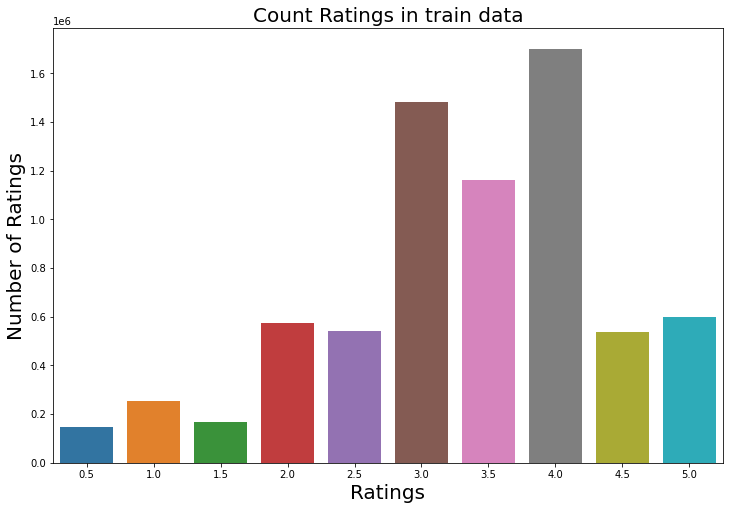

In [ ]:
#Count the number of ratings in the training dataset
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=train_data)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [ ]:
#Find the number of rated movies per user:
no_rated_movies_per_user = train_data.groupby(by = "userId")["rating"].count().sort_values(ascending = False)
no_rated_movies_per_user.head()

userId
72315     32202
80974      9178
33844      7919
20055      7488
109731     6647
Name: rating, dtype: int64

In [ ]:
#Find the number of ratings for each movie
no_ratings_per_movie = train_data.groupby(by = "movieId")["rating"].count().sort_values(ascending = False)
no_ratings_per_movie.head()

movieId
2571    7248
356     7137
296     6964
480     6871
1270    6866
Name: rating, dtype: int64

In [ ]:
#Create user-item sparse matrix function
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.userId, df.movieId)))
    return sparse_data

In [ ]:
#create user-item train sparse matrix
train_sparse_data = get_user_item_sparse_matrix(train_data)
train_sparse_data.shape

(130085, 209164)

In [ ]:
#Create user-item test matrix
test_sparse_data = get_user_item_sparse_matrix(test_data)

In [ ]:
#Global Average Rating
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))

Global Average Rating: 3.3226267458030416


In [ ]:
#Calculate the average rating
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

In [ ]:
#Average Rating User
average_rating_user = get_average_rating(train_sparse_data, True)
#average_rating_user

In [ ]:
#Average Rating Movie
avg_rating_movie = get_average_rating(train_sparse_data, False)
#avg_rating_movie

In [ ]:
#Check for Cold Start Users
total_users = len(np.unique(filtered_ratings["userId"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
                  
print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data= {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users = 9713
No. of Users in train data= 7769
No. of Users not present in train data = 1944(20.0%)


In [ ]:
#Check for Cold Start of Movies
total_movies = len(np.unique(filtered_ratings["movieId"]))
train_movies = len(avg_rating_movie)
uncommonMovies = total_movies - train_movies
                  
print("Total no. of Movies = {}".format(total_movies))
print("No. of Movies in train data= {}".format(train_movies))
print("No. of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Movies = 57589
No. of Movies in train data= 56203
No. of Movies not present in train data = 1386(2.0%)


In [ ]:
row_index, col_index = train_sparse_data.nonzero()
rows = np.unique(row_index)
col_index.shape

(7168048,)

In [ ]:
for row in rows[:100]:
  print(row)

3
12
72
80
120
166
171
175
181
187
226
243
285
321
357
426
431
440
446
450
477
494
519
541
548
572
597
606
626
648
653
695
707
757
801
803
805
828
846
847
848
858
859
860
871
901
904
919
927
939
947
983
997
1038
1048
1067
1089
1146
1203
1228
1243
1281
1288
1305
1367
1401
1405
1409
1436
1463
1474
1477
1480
1484
1503
1610
1612
1652
1704
1745
1748
1822
1831
1833
1854
1866
1894
1899
1920
1935
1974
1975
1977
1991
2003
2004
2006
2012
2032
2054


In [ ]:
#Compute User similarity matrix
#This is computationally heavy so it will be done for top 100 users
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(206000).reshape(2060,100)
    
    for row in rows[:limit]:
      sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
      similar_indices = sim.argsort()[-limit:]
      similar = sim[similar_indices]
      similar_arr[row] = similar
    
    return similar_arr

In [ ]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

In [ ]:
#Create Sample Sparse Matrix
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_movies):
    users, movies, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15) 
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    movie = np.random.choice(uniq_movies, no_of_movies, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(movies, movie))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(user)+1, max(movie)+1))
    return sparse_matrix

In [ ]:
#Sample Sparse Matrix for the Training Data
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 400, 40)

In [ ]:
#Sample Sparse Matrix for the Test Data
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 200, 20)

In [ ]:
#Generate Similar Features
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_movies = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open("new_features.csv", mode = "w")
    
    for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(movie)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())
        
        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, movie].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        top_similar_user_ratings.extend([global_avg_rating[movie]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)
        
        similar_movies = cosine_similarity(sample_sparse_matrix[:,movie].T, sample_sparse_matrix.T).ravel()
        similar_movies_indices = np.argsort(-similar_movies)[1:]
        similar_movies_ratings = sample_sparse_matrix[user, similar_movies_indices].toarray().ravel()
        top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
        top_similar_movie_ratings.extend([global_avg_users[user]] * (5-len(top_similar_movie_ratings)))
        similar_arr.extend(top_similar_movie_ratings)
        
        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_movies[movie])
        similar_arr.append(rating)
        
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', names = ["userId", "movieId", "gloabl_average", "similar_user_rating1", 
                                                               "similar_user_rating2", "similar_user_rating3", 
                                                               "similar_user_rating4", "similar_user_rating5", 
                                                               "similar_movie_rating1", "similar_movie_rating2", 
                                                               "similar_movie_rating3", "similar_movie_rating4", 
                                                               "similar_movie_rating5", "user_average", 
                                                               "movie_average", "rating"])
    return new_features_df

In [ ]:
#Generate Similar Features for the Training Data
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

In [ ]:
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features.head()

,userId,movieId,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,6025,2195,2.764151,5.0,1.5,1.0,3.0,4.5,2.0,2.00,2.00,2.00,2.00,2.00,2.8125,2.0
1,6393,2195,2.764151,5.0,1.5,1.0,3.0,4.5,2.0,2.00,2.00,2.00,2.00,2.00,2.8125,2.0
2,12701,2195,2.764151,5.0,1.5,1.0,3.0,4.5,2.0,2.00,2.00,2.00,2.00,2.00,2.8125,2.0
3,16464,2195,2.764151,5.0,1.5,1.0,3.0,4.5,4.0,4.00,4.00,4.00,4.00,4.00,2.8125,4.0
4,25983,2195,2.764151,2.0,4.0,2.0,3.0,4.5,3.5,3.75,3.75,3.75,3.75,3.75,2.8125,4.0


In [ ]:
#Generate Similar Features for the Test Data
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)

In [ ]:
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

,userId,movieId,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,132754,936,3.4,4.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.95,4.0
1,135340,936,3.4,4.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.95,4.0
2,138269,936,3.4,4.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.95,4.0
3,138935,936,3.4,4.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.95,4.0
4,146390,936,3.4,4.0,3.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,3.95,5.0


In [ ]:
#Building Machine Learning Model
x_train = train_new_similar_features.drop(["userId", "movieId", "rating"], axis = 1)

x_test = test_new_similar_features.drop(["userId", "movieId", "rating"], axis = 1)

y_train = train_new_similar_features["rating"]

y_test = test_new_similar_features["rating"]

In [ ]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [ ]:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

[05:30:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_jobs=10, silent=False)

In [ ]:
y_pred_test = clf.predict(x_test)

In [ ]:
y_pred_test.shape

(25,)

In [ ]:
rmse_test = error_metrics(y_test, y_pred_test)
print("RMSE = {}".format(rmse_test))

RMSE = 1.622988959421034


In [ ]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

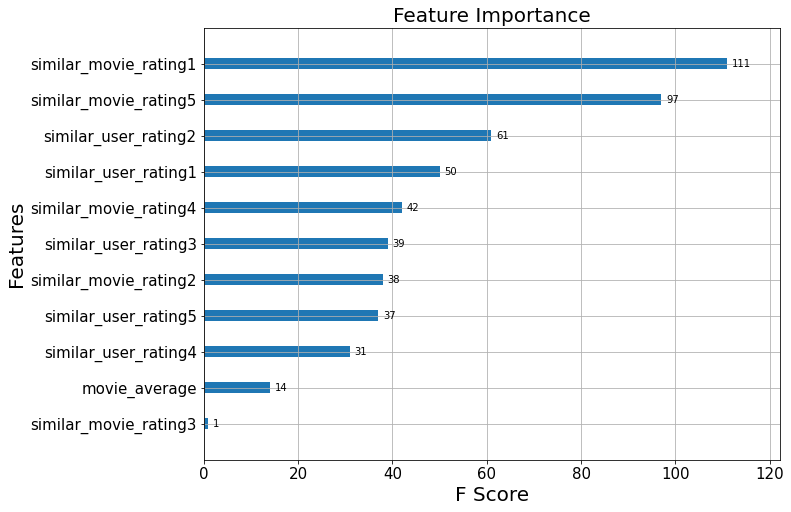

In [ ]:
plot_importance(xgb, clf)